In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns


from access_biology_data import meta, relations, properties
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

from access_science_shared import standardizer

from scipy.stats import mannwhitneyu

In [5]:
import numpy as np

In [6]:
save_images = False
outfolder = '190413_length_in_earlier_meta_studies'

In [7]:
def pretty_plot(df, col_dim):

    plt.figure(figsize=(col_dim, 5))

    sns.boxplot(
        x='tissue', 
        hue='direction', 
        y='log_length',  
        data=df,
        notch=True,
        order=sorted(df['tissue'].unique()),
        hue_order=['down', 'up']
    )

    # Put the legend out of the figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def pvals(df):
    for tissue in sorted(df['tissue'].unique()):
        d = df[df['tissue']==tissue]
        pv = mannwhitneyu(
            d[d['direction']=='up']['log_length'],
            d[d['direction']=='down']['log_length'],
            alternative='two-sided'
        )[1]
        
        insert = ''
        if pv < 0.05:
            insert='*'
        if pv < 0.01:
            insert='**'
        if pv < 0.001:
            insert='***'
                
        
        
        print(tissue, insert, pv)

In [8]:
ref_genes = standardizer.reference_genes(10090, 'orp')

pr = properties.genbank_validated_rna(10090)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])
pr = pr[pr['gene_ncbi'].isin(ref_genes)]

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [9]:
agg = []
prc = pd.merge(pr, meta.gene_info(10090, ['gene_ncbi', 'symbol_ncbi']))

tissues = {
    'tissue_independent': 'A',
    'heart': 'B',
    'liver': 'C',
    'cerebellum': 'D',
    'olfactory_bulb': 'E', 
}

for tissue in tissues.keys():

    p = inout.get_internal_path(
        'datasets/general/resources/publications/benayoun_2019/Supplemental_Table_S4.xlsx')

    df = pd.read_excel(p, tissues[tissue],header=1).rename(
        columns={'Gene Name': 'symbol_ncbi', 'Age change': 'direction'})

    
    f = df['direction'] == 'UP'
    df.loc[f, 'direction'] = 'up'
    
    
    f = df['direction'] == 'DOWN'
    df.loc[f, 'direction'] = 'down'
    
    df = pd.merge(df, prc)
    

    df = df[df['direction'].isin(['up', 'down'])]
    df.loc[:, 'tissue'] = tissue
    
    agg.append(df)

df = pd.concat(agg)

In [10]:
df.groupby(['tissue', 'direction']).size()

tissue              direction
cerebellum          down         222
                    up           329
heart               down          41
                    up           114
liver               down          71
                    up           224
olfactory_bulb      down          37
                    up           104
tissue_independent  down         112
                    up           576
dtype: int64

In [11]:
pvals(df)

cerebellum *** 1.384818891283687e-15
heart ** 0.008723004644819989
liver  0.9065835214177299
olfactory_bulb  0.8476339573223661
tissue_independent * 0.03017922533438716


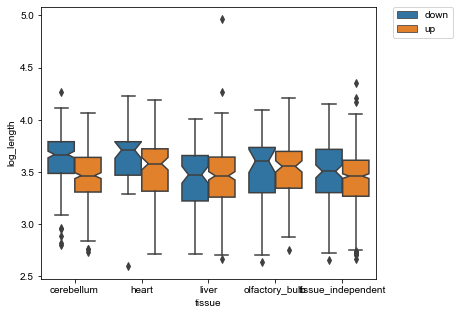

In [12]:
pretty_plot(df, 6)


if save_images:
    export.export_image('{}/mouse.pdf'.format(outfolder))

In [13]:
ref_genes = standardizer.reference_genes(10116, 'orp')

pr = properties.genbank_validated_rna(10116)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])
pr = pr[pr['gene_ncbi'].isin(ref_genes)]

In [14]:
bm = earlier_studies.bodymap()
bm = bm[bm['gene_ncbi'] != '-']
bm['gene_ncbi'] = bm['gene_ncbi'].astype(float)

In [15]:
bm = bm.rename(columns={'age_pattern': 'direction'})
bm = bm[bm['direction'].isin(['down', 'up'])]

In [16]:
df = pd.merge(bm, pr)

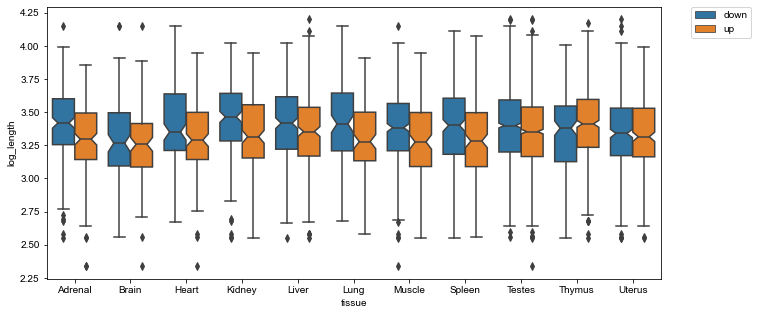

In [17]:
pretty_plot(df, 11)


if save_images:
    export.export_image('{}/rat.pdf'.format(outfolder))

In [18]:
pvals(df)

Adrenal *** 0.00032982721264014284
Brain  0.792566754405959
Heart ** 0.008136146579810636
Kidney *** 8.951721111321358e-05
Liver  0.05619125680409919
Lung ** 0.0022667353853049756
Muscle ** 0.0010833891544360463
Spleen *** 0.0009086368015724186
Testes *** 0.0008008238821116332
Thymus * 0.04558383392065707
Uterus  0.4822392538421989


------------ W002_W006 -----------
Adrenal *** 0.00040624141289378053
Brain  0.931046434915412
Heart *** 0.0006742933239815497
Kidney *** 2.6749314838355774e-08
Liver * 0.044285296357366964
Lung ** 0.002446170645848594
Muscle *** 5.398461460204387e-05
Spleen *** 1.7924228029113708e-07
Testes *** 1.4147091702658601e-11
Thymus  0.07358745870404218
Uterus  0.3352418607657741
------------ W006_W021 -----------
Adrenal  0.08425671547881002
Brain * 0.04372642411648474
Heart  0.5328631283192766
Kidney  0.10203710059230635
Liver  0.10821320127646075
Lung  0.5261179686617202
Muscle  0.26679427047119764
Spleen  0.6655408049794861
Testes ** 0.00560944618065236
Thymus * 0.02768723725282705
Uterus  0.9243377730220631
------------ W021_W104 -----------
Adrenal  0.30737245676399905
Brain  0.13039549131726622
Heart  0.12636150762582649
Kidney  0.09549606180749935
Liver  0.292156108528551
Lung  0.3463484336150947
Muscle  0.1011571213831749
Spleen  0.4231649138297079
Testes ** 0.005463785415675564
Thymu

<Figure size 432x288 with 0 Axes>

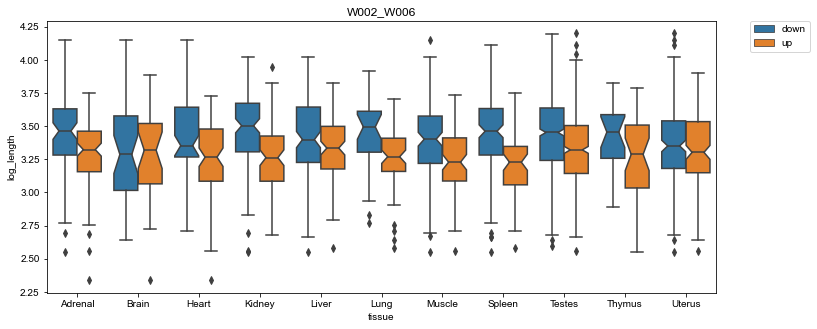

<Figure size 432x288 with 0 Axes>

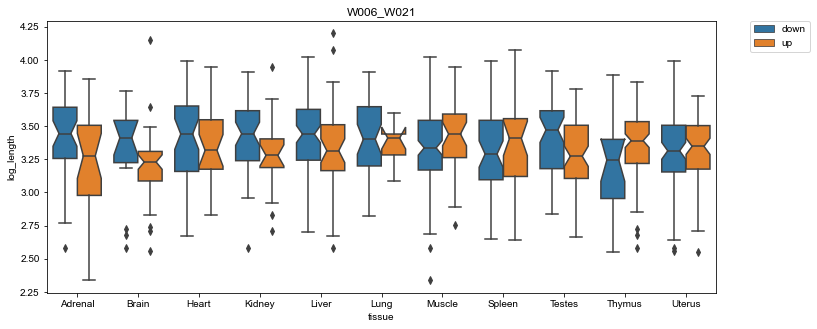

<Figure size 432x288 with 0 Axes>

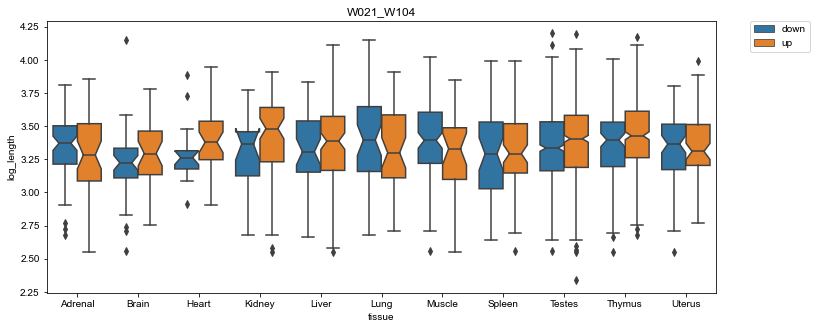

In [19]:
for age_comparison in sorted(bm['age_comparison'].unique()):
    plt.figure()
    pretty_plot(df[df['age_comparison']==age_comparison], 12)
    plt.title(age_comparison)
    

    if save_images:
        export.export_image('{}/rat_{}.pdf'.format(outfolder, age_comparison))
    
    print('------------', age_comparison, '-----------')
    pvals(df[df['age_comparison']==age_comparison])

In [20]:
agg = []

samples = {
    'brain': 'S4B',
    'liver': 'S4C',
    'skin': 'S4D'
}

path_to_data = inout.get_internal_path(
    (
        'datasets/general/resources/publications/'
        'reichwald_2015/1-s2.0-S0092867415014270-mmc5.xlsx'
    )
)

for tissue in samples.keys():

    df = pd.read_excel(
        path_to_data,
        sheet_name=samples[tissue],
        header=4
    )

    df['length'] = abs(df['End'] - df['Start'] + 1)

    df.loc[:, 'log_length'] = np.log10(df['length'])

    f = df['Log2FoldChange'] < 0
    df.loc[f, 'direction'] = 'down'
    df.loc[~f, 'direction'] = 'up'
    df.loc[:, 'tissue'] = tissue
    df.loc[:, 'tissue'] = df['tissue'].str.capitalize()
    
    
    agg.append(df)

In [21]:
df = pd.concat(agg)

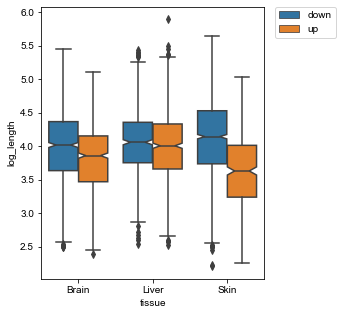

In [22]:
pretty_plot(df, 4)


if save_images:
    export.export_image('{}/killifish.pdf'.format(outfolder))

In [23]:
pvals(df)

Brain *** 3.754383346544411e-11
Liver * 0.025868389286292797
Skin *** 8.188789443279543e-43


In [24]:
df.groupby(['tissue', 'direction']).size()

tissue  direction
Brain   down          961
        up            756
Liver   down          608
        up            734
Skin    down         1452
        up            403
dtype: int64